In [20]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [21]:
data = pd.read_csv("data.csv")
print(data.head(0))
data = data.loc[:,['date','high','low','open','Volume XRP','Volume USDT','close']]
print(data.head(5))
data
#print(data.date)

Empty DataFrame
Columns: [unix, date, symbol, open, high, low, close, Volume XRP, Volume USDT]
Index: []
         date    high     low    open   Volume XRP   Volume USDT   close
0  12-27-2021  0.9237  0.9200  0.9200    2384512.0  2.198450e+06  0.9226
1  12-26-2021  0.9334  0.9052  0.9252  163438501.0  1.499400e+08  0.9200
2  12-25-2021  0.9350  0.8981  0.9114  250074945.0  2.302303e+08  0.9252
3  12-24-2021  0.9966  0.8964  0.9941  567234092.0  5.377035e+08  0.9115
4  12-23-2021  1.0167  0.9372  0.9538  479436230.0  4.729372e+08  0.9941


,date,high,low,open,Volume XRP,Volume USDT,close
0,12-27-2021,0.92370,0.92000,0.92000,2.384512e+06,2.198450e+06,0.92260
1,12-26-2021,0.93340,0.90520,0.92520,1.634385e+08,1.499400e+08,0.92000
2,12-25-2021,0.93500,0.89810,0.91140,2.500749e+08,2.302303e+08,0.92520
3,12-24-2021,0.99660,0.89640,0.99410,5.672341e+08,5.377035e+08,0.91150
4,12-23-2021,1.01670,0.93720,0.95380,4.794362e+08,4.729372e+08,0.99410
...,...,...,...,...,...,...,...
1329,5-8-2018,0.84802,0.79200,0.82490,1.297130e+07,1.057184e+07,0.80667
1330,5-7-2018,0.86886,0.80000,0.86482,1.730349e+07,1.419228e+07,0.82490
1331,5-6-2018,0.91800,0.83774,0.90280,1.600204e+07,1.399714e+07,0.86483
1332,5-5-2018,0.93500,0.88800,0.88980,1.681617e+07,1.528200e+07,0.90280


In [22]:
data = data.set_index('date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2021-12-27', '2021-12-26', '2021-12-25', '2021-12-24',
               '2021-12-23', '2021-12-22', '2021-12-21', '2021-12-20',
               '2021-12-19', '2021-12-18',
               ...
               '2018-05-13', '2018-05-12', '2018-05-11', '2018-05-10',
               '2018-05-09', '2018-05-08', '2018-05-07', '2018-05-06',
               '2018-05-05', '2018-05-04'],
              dtype='datetime64[ns]', name='date', length=1334, freq=None)


In [33]:
data.iloc[:200]

,high,low,open,Volume XRP,Volume USDT,close
date,,,,,,
2021-12-27,0.9237,0.9200,0.9200,2384512.0,2.198450e+06,0.9226
2021-12-26,0.9334,0.9052,0.9252,163438501.0,1.499400e+08,0.9200
2021-12-25,0.9350,0.8981,0.9114,250074945.0,2.302303e+08,0.9252
2021-12-24,0.9966,0.8964,0.9941,567234092.0,5.377035e+08,0.9115
2021-12-23,1.0167,0.9372,0.9538,479436230.0,4.729372e+08,0.9941
...,...,...,...,...,...,...
2021-06-15,0.9017,0.8551,0.8905,367733720.0,3.234482e+08,0.8663
2021-06-14,0.9300,0.8628,0.8833,441724628.6,3.916475e+08,0.8906
2021-06-13,0.8883,0.8170,0.8325,344882480.1,2.929336e+08,0.8832


In [24]:
aim = 'close'

In [25]:
train_data = data.iloc[200:]
test_data = data.iloc[:200]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

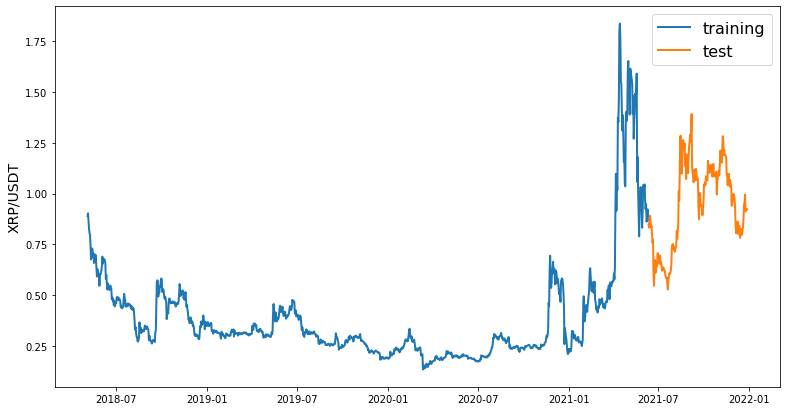

In [26]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [27]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [30]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    # copies data from continuous(dict) to window_data(nparray)
    
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        else:
            tmp = normalise_min_max(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test
import numpy as np

In [29]:
from tensorflow.keras import layers

In [31]:
def build_lstm_model(input_data, output_size, neurons, activ_func='tanh',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, 
                   input_shape=(input_data.shape[1], input_data.shape[2]) ,
                   recurrent_activation="sigmoid",))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.4
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [11]:
print(X_train.shape)

(1129, 5, 6)


In [32]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

2022-03-04 18:53:11.654481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 18:53:11.655016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 18:53:11.655080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-04 18:53:11.655125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-04 18:53:11.655169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/20
36/36 [==============================] - 2s 13ms/step - loss: 0.0177 - val_loss: 0.0062
Epoch 2/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 3/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 4/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 5/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 6/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 8/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 9/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 11/20
36/36 

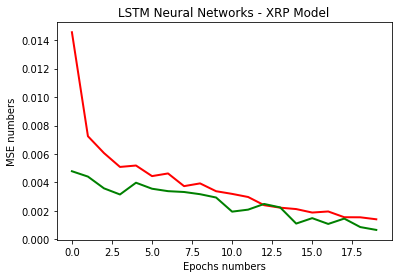

In [58]:
import matplotlib.pyplot as plt
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [25]:
len(modelfit.history['loss'])

20

In [61]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.019053015271786704

In [62]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0006646643796832899

In [63]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

94.85670501407162

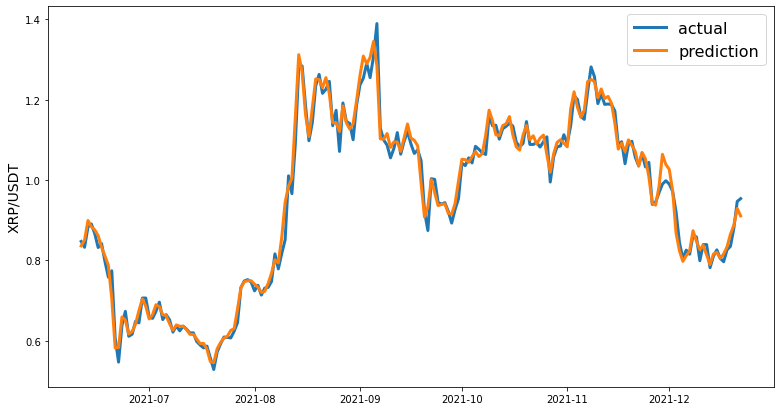

In [64]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)